In [1]:
#import  needed libraries and check the used gpu
import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid

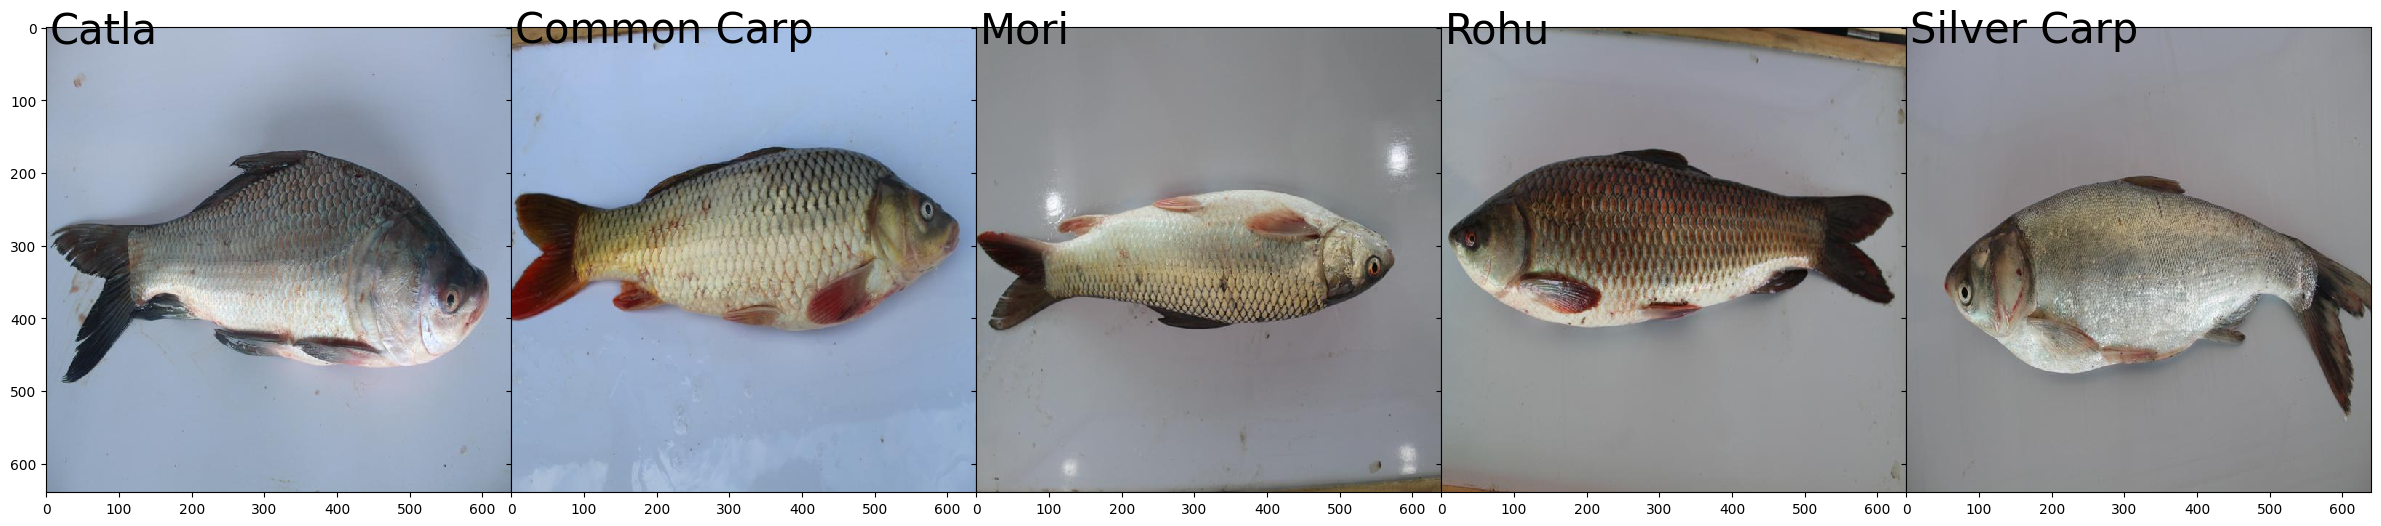

In [2]:
#Show the planned classes and its expected value
%matplotlib inline

FISH=np.array(glob.glob('gallery/*.jpg')) 

fig = plt.figure(figsize=(30, 30))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(1, 5),  
                 axes_pad=0,  # pad between axes in inch.
                 )
l=0
for img in FISH:
        im=plt.imread(img)
        grid[l].imshow(im,cmap='gray',interpolation='nearest')
        grid[l].text(5,20, img.split('\\')[1].split('.')[0] ,fontsize=30)
        l+=1

In [3]:
#creating the dataloaders 
# Define transforms for the training data and testing data
train_path='train'
valid_path='valid'

train_transforms = transforms.Compose([transforms.Resize((640,640)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((640,640)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [4]:
# load data to loaders
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(valid_path, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

#print used Device
print(f"Device used: {torch.cuda.get_device_name(0)}")

#print class to index mapping
print(f"class to index mapping: {train_data.class_to_idx}")

Device used: NVIDIA GeForce RTX 3070 Laptop GPU
class to index mapping: {'Catla': 0, 'Common Carp': 1, 'Mori': 2, 'Rohu': 3, 'Silver Carp': 4}


In [5]:
# choose a pretrained model to start with check options here: https://pytorch.org/vision/stable/models.html
model = models.mobilenet_v2(weights='DEFAULT')

# Freeze parameters of the tarined network 
for param in model.parameters():
    param.requires_grad = False
    
#print the model to check the classifer and change it
print (model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [6]:
# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=5, bias=True),
                                nn.LogSoftmax(dim=1))

# unlock last three blocks before the classifier(last layer).
for p in model.features[-3:].parameters():
    p.requires_grad = True  

    
# choose your loss function
criterion = nn.NLLLoss()

# define optimizer to train only the classifier and the previous three block.
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        {'params':model.features[-2].parameters()},
                        {'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

#print the classifier now
print(model.classifier)

#print the whole model
# print(model)

Sequential(
  (0): Dropout(p=0.6, inplace=False)
  (1): Linear(in_features=1280, out_features=5, bias=True)
  (2): LogSoftmax(dim=1)
)


image number 20
---------------------
label: Common Carp
prediction: Silver Carp


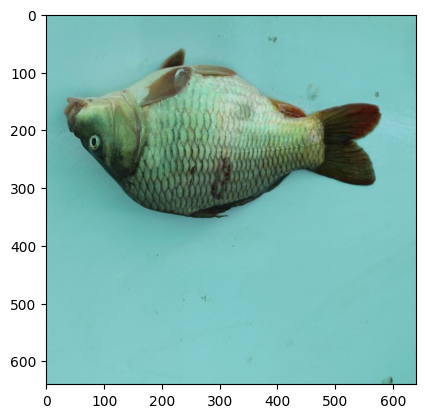

In [7]:
### try your model on some images
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#turn model to evaluation mode
model.eval()

#load some of the test data 
test_data_t = datasets.ImageFolder(valid_path,transforms.Compose([transforms.ToTensor()]))
testloader_t = torch.utils.data.DataLoader(test_data_t, batch_size=25,shuffle=True)
images_t , labels_t=next( iter(testloader_t) )

#Choose arandom image from 0 to 24
index = np.random.randint(0, 24)
test_img=images_t[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0).cuda()

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels_t[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])

In [8]:
#Define number of epochs through data and run the training loop
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 2
step = 0
running_loss = 0
print_every = 2
trainlossarr=[]
testlossarr=[]
oldacc=0

steps=math.ceil(len(train_data)/(trainloader.batch_size))

In [9]:
%%time
from tqdm import tqdm
from colorama import Fore,Style
import sys

for epoch in range(epochs):
    print(Style.RESET_ALL)
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")
    for inputs, labels in tqdm(trainloader,desc=Fore.GREEN +f"* PROGRESS IN EPOCH {epoch+1} ",file=sys.stdout):
        model.train()
        step += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step % print_every == 0) or (step==steps):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
 
                    
                        

            tqdm.write(f"Epoch ({epoch+1} of {epochs}) ... "
                  f"Step  ({step:3d} of {steps}) ... "
                  f"Train loss: {running_loss/print_every:.3f} ... "
                  f"Test loss: {test_loss/len(testloader):.3f} ... "
                  f"Test accuracy: {accuracy/len(testloader):.3f} ")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
            running_loss = 0
            
        
    scheduler.step()
    step=0


--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

Epoch (1 of 2) ... Step  (  2 of 12) ... Train loss: 1.619 ... Test loss: 1.568 ... Test accuracy: 0.405               s/it]
Epoch (1 of 2) ... Step  (  4 of 12) ... Train loss: 1.527 ... Test loss: 1.506 ... Test accuracy: 0.473               s/it]
Epoch (1 of 2) ... Step  (  6 of 12) ... Train loss: 1.415 ... Test loss: 1.420 ... Test accuracy: 0.609               s/it]
Epoch (1 of 2) ... Step  (  8 of 12) ... Train loss: 1.406 ... Test loss: 1.302 ... Test accuracy: 0.770               s/it]
Epoch (1 of 2) ... Step  ( 10 of 12) ... Train loss: 1.225 ... Test loss: 1.137 ... Test accuracy: 0.906               s/it]
Epoch (1 of 2) ... Step  ( 12 of 12) ... Train loss: 1.123 ... Test loss: 0.946 ... Test accuracy: 0.949               s/it]
* PROGRESS IN EPOCH 1 : 100%|██████████████████████████████████████████████████████████| 12/12 [01:06<00:00,  5.58s/it]

---------------------

In [10]:
### try your model on some images
%matplotlib inline

#turn model to evaluation mode
model.eval()

#load some of the test data 
test_data = datasets.ImageFolder(valid_path,transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(test_data, batch_size=50,shuffle=True)
images , labels=next( iter(testloader) )

image number 34
---------------------
label: Mori
prediction: Mori


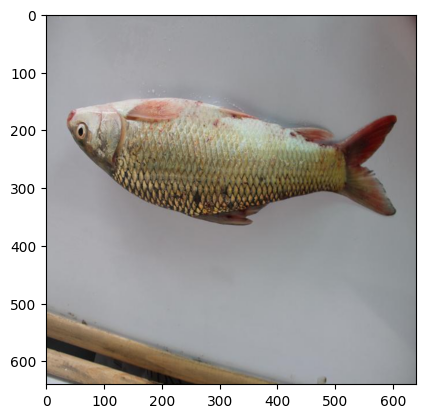

In [11]:
#Choose arandom image from 0 to 199
index = np.random.randint(0, 49)
test_img=images[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0).cuda()

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])